In [1]:
%load_ext jupyter_black

In [11]:
from typing import NewType, Iterable, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from sklearn.decomposition import PCA

from sppp.transfer.const import GridSpace

grid = GridSpace()
idx: slice = pd.IndexSlice

In [14]:
PROB_SEVERE = 90


def load_parquet(path: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    mask = df.columns[~df.columns.isin(("MAXRC_EMISS", "MAXRC_ICECF", "geometry"))]
    df[mask] = df[mask].astype(np.float32)
    return df


df_2021 = load_parquet("/workspaces/sppp/data/2021-10.parquet")
df_2022 = load_parquet("/workspaces/sppp/data/2022-07.parquet")
# df_2021

In [4]:
ps_100_2021 = df_2021.loc[df_2021["PS"] == PROB_SEVERE].index.unique("ID")

In [5]:
ps_100_2022 = df_2022.loc[df_2022["PS"] == PROB_SEVERE].index.unique("ID")

In [6]:
def x_and_y(df: pd.DataFrame, grid: GridSpace) -> pd.DataFrame:
    """calculate geometric center of storm and fit the stom to the gridspace"""
    
    def generate():
        for arr in df["geometry"]:
            point = Polygon(arr.tolist()).centroid
            yield point.x, point.y

    x, y = np.array(tuple(generate()), dtype=np.float32).T
    # index position of nearest grid
    df["X"] = np.argmin(abs(x[:, np.newaxis] - grid.x), axis=1)
    df["Y"] = np.argmin(abs(y[:, np.newaxis] - grid.y), axis=1)

    return df


gdf_2021 = df_2021.pipe(x_and_y, grid).drop(
    columns=["geometry", "MAXRC_EMISS", "MAXRC_ICECF"],  # string object float values
)
gdf_2022 = df_2022.pipe(x_and_y, grid).drop(
    columns=["geometry", "MAXRC_EMISS", "MAXRC_ICECF"],  # string object float values
)

In [7]:
gdf_2022.shape, gdf_2021.shape
assert (gdf_2021.dtypes == gdf_2022.dtypes).all()

In [8]:
# unique storms with a 100% ProbSevere
_2021 = gdf_2021.loc[idx[:, ps_100_2021], :]
_2022 = gdf_2022.loc[idx[:, ps_100_2022], :]

In [9]:
columns = [
    "PS",
    "X",
    "Y",
    "MOTION_EAST",
    "MOTION_SOUTH",
    "MLCIN",
    "MUCAPE",
    "MLCAPE",
    "MESH",
    "VIL_DENSITY",
]


def embed(df: pd.DataFrame) -> pd.DataFrame:
    # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform
    # Principal component analysis (PCA).
    pca = PCA(n_components=1, svd_solver="arpack")
    df["CAPE"] = pca.fit_transform(
        df[
            [
                "MLCIN",
                "MUCAPE",
                "MLCAPE",
            ]
        ]
    )

    return df[
        ["PS", "X", "Y", "MOTION_EAST", "MOTION_SOUTH", "CAPE", "MUCAPE", "MLCAPE"]
    ]


def resize_ps(df: pd.DataFrame) -> pd.DataFrame:
    df["PS"] = df["PS"] * (df["PS"] * 0.010)
    return df

<AxesSubplot:xlabel='X', ylabel='Y'>

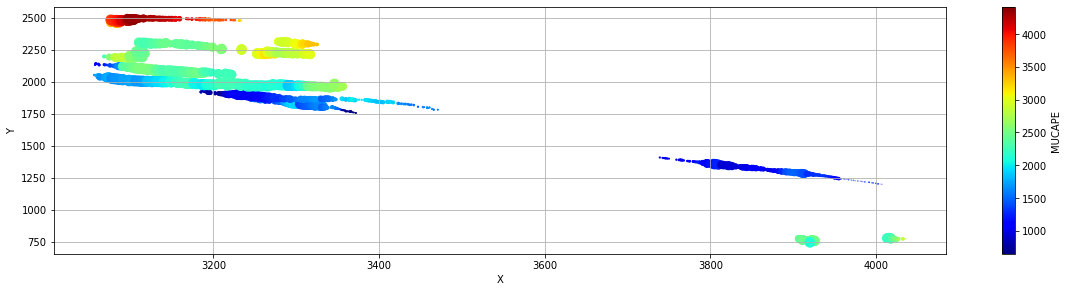

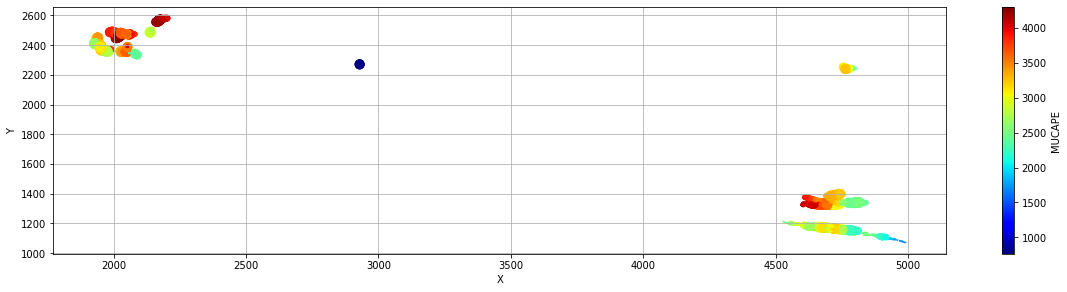

In [10]:
plt.rcParams["axes.grid"] = True
#
plt.figure(1)
ax1 = plt.subplot(211)
_2021.copy()[columns].pipe(embed).pipe(resize_ps).plot.scatter(
    x="X",
    y="Y",
    c="MUCAPE",
    s="PS",
    cmap=plt.get_cmap("jet"),
    ax=ax1,
    figsize=(20, 10),
)
plt.figure(2)
ax2 = plt.subplot(211)
_2022.copy()[columns].pipe(embed).pipe(resize_ps).plot.scatter(
    x="X",
    y="Y",
    c="MUCAPE",
    s="PS",
    cmap=plt.get_cmap("jet"),
    ax=ax2,
    # ax=axs[0, 1],
    figsize=(20, 10),
)